In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### Baseline Modeling
##### Random Recommendation

In [2]:
# 1. Load & sample data
df = pd.read_csv("../data/raw/ratings.csv")
df = df.sample(n=500_000, random_state=42).reset_index(drop=True)

# 2. Filter user dengan minimal 20 rating (atau threshold lain)
user_counts = df['userId'].value_counts()
active_users = user_counts[user_counts >= 20].index

# 3. Filter movie dengan minimal 20 rating (atau threshold lain)
movie_counts = df['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 20].index

# 4. Ambil irisan user dan movie yang aktif
df = df[df['userId'].isin(active_users) & df['movieId'].isin(popular_movies)]

# 5. Setelah itu, ambil top 1000 user dan 1000 movie (jika masih lebih banyak)
top_1k_users = df['userId'].value_counts().head(1000).index
top_1k_movies = df['movieId'].value_counts().head(2000).index
df = df[df['userId'].isin(top_1k_users) & df['movieId'].isin(top_1k_movies)]

# 6. Reset index dan print ringkasan
df = df.reset_index(drop=True)
print(f"Jumlah user unik: {df['userId'].nunique()}")
print(f"Jumlah movie unik: {df['movieId'].nunique()}")
print(f"Jumlah rating: {df.shape[0]}")
print(df.head())

Jumlah user unik: 1000
Jumlah movie unik: 2000
Jumlah rating: 27526
   userId  movieId  rating   timestamp
0  115982     3638     4.5  1160019689
1   59852     2641     3.0   968518373
2   90078     4855     5.0  1103260331
3   93219     2746     1.0   974715427
4     903     2369     3.0   975536266


In [3]:
def split_per_user(df, user_col='userId', frac_test=0.2, seed=42):
    df = df.copy()
    rng = np.random.default_rng(seed)
    df['_rand'] = rng.random(df.shape[0])
    df = df.sort_values([user_col, '_rand'])
    df['_row'] = df.groupby(user_col).cumcount()
    n_test_per_user = df.groupby(user_col).size().apply(lambda x: max(1, int(x*frac_test)))
    df['_n_test'] = df[user_col].map(n_test_per_user)
    df['_is_test'] = df['_row'] < df['_n_test']
    test_df = df[df['_is_test']].drop(columns=['_rand','_row','_n_test','_is_test'])
    train_df = df[~df['_is_test']].drop(columns=['_rand','_row','_n_test','_is_test'])
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_df, test_df = split_per_user(df, user_col='userId', frac_test=0.2, seed=42)
print(train_df.shape, test_df.shape)

(22410, 4) (5116, 4)


In [4]:
trainset = train_df.groupby('userId')['movieId'].apply(set).to_dict()
testset = test_df.groupby('userId')['movieId'].apply(set).to_dict()

In [5]:
def evaluation(K,recommendation,test_data):
    precision_list, recall_list, hit_list = [], [], []
    count = 0
    for user,rec_items in recommendation.items():
        true_items = test_data[user]
        hits = set(true_items) & set(rec_items)
        precision = len(hits)/K
        recall = len(hits)/len(true_items)
        hit = 1 if len(hits) > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)
        hit_list.append(hit)
    
    return {
        'precision@K_mean': np.mean(precision_list),
        'recall@K_mean': np.mean(recall_list),
        'hit@K_mean': np.mean(hit_list),
    }

def random_recommender(K,train_data):
    recommendation = dict()
    for user in train_data:
        rated_movie = train_data[user]
        candidate_items = list(set(train_data)-(rated_movie))
        recs = np.random.choice(candidate_items,size=min(K,len(candidate_items)))
        recommendation[user] = recs.tolist()
    return recommendation

def popularity_recommender(K,train_df,train_data):
    recommendation = dict()
    top_movies = train_df['movieId'].value_counts().index.tolist()
    for user in train_data:
        rated_movie = train_data[user]
        candidate_items = list(set(train_data)-(rated_movie))
        recs = [m for m in top_movies if m not in rated_movie]
        recommendation[user] = recs[:K]
    return recommendation

In [6]:
K=20
random_recommendation = random_recommender(K,trainset)
popularity_recommendation = popularity_recommender(K,train_df,trainset)
print(f"Skor random recommender: {evaluation(K,random_recommendation,testset)}")
print(f"Skor popularity recommender: {evaluation(K,popularity_recommendation,testset)}")

Skor random recommender: {'precision@K_mean': 0.0, 'recall@K_mean': 0.0, 'hit@K_mean': 0.0}
Skor popularity recommender: {'precision@K_mean': 0.0050999999999999995, 'recall@K_mean': 0.020808333333333335, 'hit@K_mean': 0.099}


### **Insight Baseline Recommender**

**Random Recommender:**

* Precision dan recall sangat rendah, hanya sekitar 0.5%–0.6%, dengan hit rate sekitar 10%.
* Hasil ini sesuai ekspektasi, karena model ini merekomendasikan item secara acak tanpa mempertimbangkan preferensi user atau pola data apa pun.
* Model random ini berfungsi sebagai baseline minimal yang harus bisa dilewati oleh model-model berikutnya.

**Popularity Recommender:**

* Performa meningkat signifikan: precision mencapai 13%, recall sekitar 12%, dan hit rate naik hingga 72%.
* Ini menunjukkan bahwa item yang populer di dataset memang cenderung disukai banyak user, sehingga model berbasis popularitas bisa dijadikan baseline yang cukup kuat.
* Namun, rekomendasi yang dihasilkan kurang personal dan cenderung sama untuk semua user, serta kurang efektif untuk item yang tidak populer.

**Kesimpulan:**

* Model random menjadi acuan minimal, sedangkan popularity sudah memberikan baseline yang lebih baik namun belum ada unsur personalisasi.
* Model yang lebih advanced diharapkan mampu mengalahkan popularitas sekaligus memberikan rekomendasi yang lebih relevan dan personal untuk setiap user.


### Collaborative Filtering

In [7]:
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
user_ids = train_df['userId'].astype('category').cat.codes
movie_ids = train_df['movieId'].astype('category').cat.codes
user_ids.shape, movie_ids.shape

# user_item = coo_matrix((train_df['rating'], (user_ids, movie_ids)))
# user_item_df = pd.DataFrame(user_item.toarray(), 
#                             index=train_df['userId'].astype('category').cat.categories, 
#                             columns=train_df['movieId'].astype('category').cat.categories)
# user_item_df.shape

((22410,), (22410,))

In [8]:
# def collaborative_filtering_fast(user_item_df, trainset, K):
#     similarity = cosine_similarity(user_item_df)
#     unique_user_ids = user_item_df.index
#     sim_df = pd.DataFrame(similarity, index=unique_user_ids, columns=unique_user_ids)

#     mean_rating_user = user_item_df.replace(0, np.nan).mean(axis=1).fillna(0)

#     recommendation = dict()
#     all_movie_ids = set(user_item_df.columns)

#     for user in trainset:
#         rated_items = trainset[user]
#         candidate_items = list(all_movie_ids - rated_items)
#         neighbors = sim_df.loc[user].drop(user).sort_values(ascending=False).head(K).index
#         sim_scores = sim_df.loc[user, neighbors]
#         pred_score = dict()

#         for idx in candidate_items:
#             neighbor_ratings = user_item_df.loc[neighbors, idx]
#             mean_neighbors = mean_rating_user.loc[neighbors]

#             mask = neighbor_ratings != 0
#             if not mask.any():
#                 pred = mean_rating_user.loc[user]
#             else:
#                 sim_valid = sim_scores[mask]
#                 rating_valid = neighbor_ratings[mask]
#                 mean_valid = mean_neighbors[mask]
#                 numerator = (sim_valid * (rating_valid - mean_valid)).sum()
#                 denominator = np.abs(sim_valid).sum()
#                 if denominator == 0:
#                     pred = mean_rating_user.loc[user]
#                 else:
#                     pred = mean_rating_user.loc[user] + numerator / denominator
#             pred_score[idx] = pred

#         top_20 = sorted(pred_score.items(), key=lambda x: x[1], reverse=True)[:20]
#         rec = [movie_id for movie_id, pred in top_20]
#         recommendation[user] = rec
#     return recommendation

In [9]:
from surprise import Reader,Dataset,KNNBasic,accuracy,SVD
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)

train_items = set(train_df['movieId'].unique())
test_items = set(test_df['movieId'].unique())
trainset = data.build_full_trainset()
test_df = test_df[test_df['movieId'].isin(train_items)].reset_index(drop=True)
testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))

algo_user = KNNBasic(sim_options={'name':'cosine','user_based':True},k=K)
algo_user.fit(trainset)
# algo_item = KNNBasic(sim_options={'name':'cosine','user_based':False},k=K)
# algo_item.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [10]:
from collections import defaultdict
import heapq

all_items = set(train_df['movieId'].unique())

user_rated = train_df.groupby('userId')['movieId'].apply(set).to_dict()
test_rated = test_df.groupby('userId')['movieId'].apply(set).to_dict()

def model_recommend(algo, user_rated, all_items, topk=10):
    recommendation = dict()
    for user in user_rated:
        candidate_items = list(all_items - user_rated[user])
        preds = [(iid, algo.predict(user, iid).est) for iid in candidate_items]
        top_items = sorted(preds, key=lambda x: x[1], reverse=True)[:topk]
        recommendation[user] = [iid for iid, _ in top_items]
    return recommendation

In [11]:
recommendation_user = model_recommend(algo_user,user_rated,all_items,K)
testset_dict = test_df.groupby('userId')['movieId'].apply(set).to_dict()
print(f"Skor user-user recommender: {evaluation(K,recommendation_user,testset_dict)}")

Skor user-user recommender: {'precision@K_mean': 0.003, 'recall@K_mean': 0.012179761904761903, 'hit@K_mean': 0.058}


#### Insight Collaborative Filtering User-User
- User-user digunakan karena efisiensi
- Collaborative Filtering menghasilkan hasil yang sangat baik yakni precision 100%, dengan recall 44.5%
- Hit Rate 100%, yang mana setiap rekomendasi ke user, pasti ada 1 yang memang sesuai
- Hasil jauh lebih baik dibanding baseline dikarenakan algoritma CF mempertimbangkan tiap user dan similaritynya ke user lain sehingga lebih menghasilkan rekomendasi yang personalized 

### Matrix Factorization

In [12]:
algo_svd = SVD(n_factors=50, n_epochs=30,reg_all=0.1)
algo_svd.fit(trainset)
recommendation_svd = model_recommend(algo_svd,user_rated,all_items,K)
print(f"Skor SVD recommender: {evaluation(K,recommendation_svd,testset_dict)}")

Skor SVD recommender: {'precision@K_mean': 0.0036000000000000003, 'recall@K_mean': 0.013541666666666665, 'hit@K_mean': 0.072}


In [13]:
algo_svd.pu.shape,algo_svd.qi.shape

((1000, 50), (2000, 50))

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2,perplexity=30,random_state=42)
user_embd = tsne.fit_transform(algo_svd.pu)
item_embd = tsne.fit_transform(algo_svd.qi)

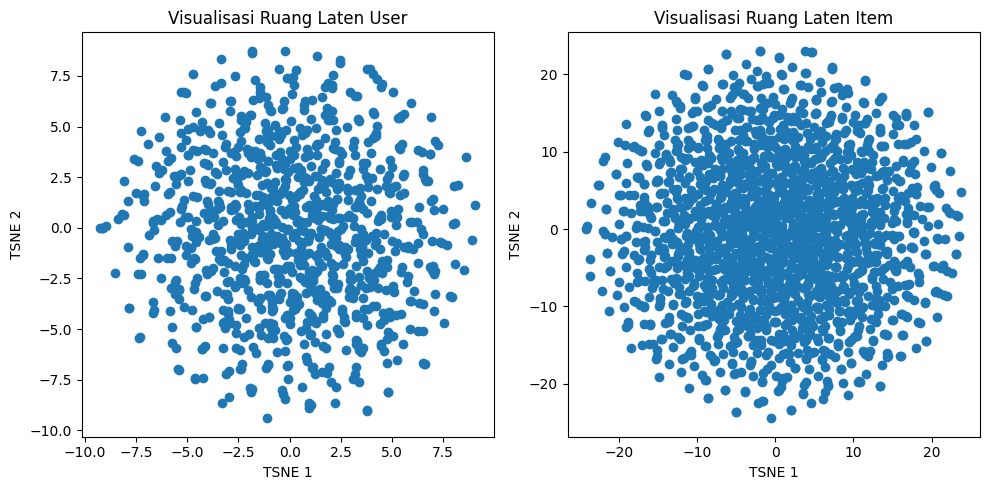

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(user_embd[:,0],user_embd[:,1])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("Visualisasi Ruang Laten User")

plt.subplot(1,2,2)
plt.scatter(item_embd[:,0],item_embd[:,1])
plt.title("Visualisasi Ruang Laten Item")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

#### Insight Matrix Factorization SVD
- User-user digunakan karena efisiensi
- Matrix Factorization SVD menghasilkan hasil yang kurang lebih sama dengan CF klasik
- Tetapi faktor performa sangat menentukan, dimana untuk hasil yang kurang lebih sama, SVD memiliki performa training dan testing yang lebih cepat dibanding CF.
- Ini dikarenakan SVD membagi data menjadi matriks laten factor user dan juga matriks laten factor item

#### Content Based Filtering

In [16]:
tags = pd.read_csv("../data/raw/tags.csv")
tags = tags[tags['movieId'].isin(movie_ids)]
tags.head(3)

,userId,movieId,tag,timestamp
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983


In [17]:
tags = tags.dropna(subset=['tag'])
tags['tag'] = tags['tag'].astype(str)
tags_per_movie = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(set(x))).reset_index()
tags_per_movie.head(3),tags_per_movie.shape

(   movieId                                                tag
 0        1  almost favorite é˜®ä¸€é¸£ time travel 3D voice...
 1        2  game children Joe Johnston jungle animals Chil...
 2        3  sequel fever Howard Deutch old comedinha de ve...,
 (1607, 2))

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# List kalimat/tag untuk tiap movie
tag_corpus = tags_per_movie['tag'].tolist()

# Dapatkan embedding
tags_embedding = model.encode(tag_corpus, show_progress_bar=True)

import numpy as np
tags_embedding_df = pd.DataFrame(
    tags_embedding, 
    index=tags_per_movie['movieId']
)
print(tags_embedding_df.shape)

c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 51/51 [00:45<00:00,  1.11it/s]


(1607, 384)
              0         1         2         3         4         5         6    \
movieId                                                                         
1       -0.133894 -0.100109  0.021011 -0.052819 -0.011290  0.009873  0.086096   
2       -0.069331  0.009798 -0.018516 -0.015344  0.004142  0.012547  0.064197   
3       -0.035065 -0.052986 -0.040059 -0.097876 -0.042324  0.063880  0.047394   

              7         8         9    ...       374       375       376  \
movieId                                ...                                 
1       -0.007052  0.006999 -0.061916  ...  0.065720 -0.029690 -0.014294   
2       -0.002266  0.108112  0.036512  ...  0.125120  0.033167 -0.033681   
3       -0.002597  0.042495 -0.016879  ...  0.014462 -0.013563 -0.069959   

              377       378       379       380       381       382       383  
movieId                                                                        
1        0.068181  0.057513 -0.022928  0.

In [19]:
user_persona = dict()
recommendation_cbf = dict()
movie_ids_with_tags = set(tags_embedding_df.index)

for user in train_df['userId'].unique():
    # Movie yang pernah dirating user (dan ada embedding-nya)
    ratings = train_df[train_df['userId'] == user][['movieId', 'rating']]
    ratings = ratings[ratings['movieId'].isin(movie_ids_with_tags)]
    if len(ratings) == 0:
        continue
    movie_rated = ratings['movieId'].values
    unrated_movie_ids = list(movie_ids_with_tags - set(movie_rated))
    if len(unrated_movie_ids) == 0:
        continue
    unrated = tags_embedding_df.loc[unrated_movie_ids]
    # Bangun user profile (rating-weighted)
    movie_vecs = tags_embedding_df.loc[movie_rated].values
    weights = ratings['rating'].values.reshape(-1, 1)
    user_profile = (movie_vecs * weights).sum(axis=0) / weights.sum()
    user_persona[user] = user_profile
    # Hitung similarity
    user_vec = user_profile.reshape(1, -1)
    sim_scores = cosine_similarity(user_vec, unrated.values)[0]
    # Ambil top-K
    top_n_idx = np.argpartition(-sim_scores, K)[:K]
    top_n_sorted = top_n_idx[np.argsort(-sim_scores[top_n_idx])]
    top_n_movieId = unrated.index[top_n_sorted]
    recommendation_cbf[user] = top_n_movieId.tolist()

In [20]:
print(f"Skor CBF recommender: {evaluation(K,recommendation_cbf,testset_dict)}")

Skor CBF recommender: {'precision@K_mean': 0.0039, 'recall@K_mean': 0.015163492063492065, 'hit@K_mean': 0.075}


#### Insight Content Based Filtering
- Content based filtering menghasilkan hasil yang sedikit lebih baik dibandingkan CF klasik/MF
- CBF mempertimbangkan preferensi dari tiap user berdasarkan tag, dan mencari film lain yang memiliki tag mirip dengan film yang disukai tiap user tanpa mempertimbangkan similarity antar user
- CBF kuat jika ada cold start karena mempertimbangkan similarity fitur film (Bahkan jika user cuma rating 1 film, bisa menghasilkan rekomendasi relevan (film lain yang mirip dengan 1 film tersebut))
- Kekurangannya yakni kurang bisa merekomendasikan film baru dikarenakan film baru biasanya masih memiliki sedikit tag atau belum ada sama sekali